In [232]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import gurobipy as gp
from gurobipy import GRB

In [233]:
# 価格を生成する関数
def create_price(r_min, r_max, M):
    # r_minとr_maxの間のランダムな0.1刻みの少数をM個生成
    price = np.random.uniform(r_min, r_max, M)
    price = np.round(price, 1)

    return price

In [234]:
create_price(0.6, 1.0, 10)

array([1. , 0.7, 0.8, 0.9, 0.8, 0.7, 0.8, 0.7, 0.6, 0.9])

In [235]:
# alphaを作成する関数
def alpha_star(M):
    alpha_star = np.random.uniform(M, 3 * M, size=M)
    return alpha_star

In [236]:
# betaを作成する関数
def beta_star(M, M_prime):
    beta_star = np.zeros((M, M_prime))

    for m in range(M):
        for m_prime in range(M_prime):
            if m == m_prime:
                beta_star[m, m_prime] = np.random.uniform(-2 * M, -M)
            else:
                beta_star[m, m_prime] = np.random.uniform(0, 2)

    return beta_star

In [275]:
def sales_function(price, alpha, beta):
    #
    M = len(price)
    sales_list = []

    for m in range(M):
        sum_beta = 0
        for m_prime in range(M):
            sum_beta += beta[m][m_prime] * price[m_prime]

        quantity = alpha[m] + sum_beta
        sales_list.append(quantity * price[m])

    return sales_list


In [259]:
# 目的関数の定義（売上の負の値を返す）
def objective_function(prices, coef, intercept):
    # 価格に基づく売上の予測
    sales = 0

    for i in range(len(prices)):
        sales += coef[i] * prices[i]

    sales += intercept

    # 売上を最大化するために、負の値を返す（minimizeは最小化を行うため）
    return sales

In [260]:
M = 20
r_m = 0.6
r_M = 1.0
initial_prices = np.full(M, 0.8)

In [261]:
M = 20

# このデータにおけるalpha,betaを作成
alpha = alpha_star(M)
beta = beta_star(M, M)
r_m = 0.6
r_M = 1.0
# 価格を入れるリスト
price_list = []
# 売上を入れるリスト
sales_list = []

# 価格と対応する売上を10000件生成
for i in range(500):
    price = create_price(r_m, r_M, M)
    price_list.append(price)
    sales = sales_function(price, alpha, beta)
    sales_list.append(sales)

In [ ]:
sales_function()

In [262]:
# 列名を作成
columns = []
for m in range(M):
    columns.append("product_" + str(m))

# データフレームを作成
df_price = pd.DataFrame(price_list, columns=columns)

# 売上を追加
df_price["sales"] = sales_list

# 売上をfloatに
df_price["sales"] = df_price["sales"].astype(float)

df_price.head()

,product_0,product_1,product_2,product_3,product_4,product_5,product_6,product_7,product_8,product_9,...,product_11,product_12,product_13,product_14,product_15,product_16,product_17,product_18,product_19,sales
0,0.9,0.6,0.6,0.7,0.8,0.8,0.8,0.9,1.0,0.9,...,0.8,0.9,0.7,0.8,0.9,0.7,0.8,0.8,0.7,552.778377
1,1.0,0.7,0.9,0.8,0.9,0.8,0.9,0.8,0.7,0.8,...,0.8,0.8,1.0,0.8,0.6,0.9,0.9,0.7,0.9,571.089023
2,0.6,0.9,0.9,0.7,0.8,0.6,0.6,0.6,0.8,0.7,...,0.7,0.8,0.7,0.7,1.0,0.8,0.7,1.0,0.7,521.181038
3,1.0,0.9,0.7,0.7,0.7,0.7,0.9,0.9,1.0,1.0,...,0.7,0.8,0.8,0.7,0.8,0.7,0.6,0.9,0.9,550.292586
4,0.9,0.9,0.8,0.7,0.9,0.6,0.8,0.8,0.8,0.8,...,0.7,1.0,0.7,0.8,0.7,0.9,0.7,0.6,0.9,548.764655


In [273]:
(sum(beta[0] * df_price.iloc[0, :-1]) + alpha[0]) * df_price.iloc[0, 0]

25.762853260279307

In [263]:
# データを説明変数と目的変数に分割
X = df_price.drop("sales", axis=1)
Y = df_price["sales"]

# 訓練データとテストデータに分割
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [264]:
# 売上の線形回帰式を学習
lr = LinearRegression()
lr.fit(X_train, Y_train)

# 係数と切片を取得
coef = lr.coef_
intercept = lr.intercept_

print(coef)
print(intercept)

# gurobiでこの線形回帰式を最大化

# モデルの作成
m = gp.Model("max_sales")

# 変数の作成
prices = m.addVars(M, lb=r_m, ub=r_M, name="prices")

# 目的関数の設定
m.setObjective(gp.quicksum(coef[i] * prices[i] for i in range(M)) + intercept, GRB.MAXIMIZE)

# 最適化
m.optimize()

# 結果の表示
print("Optimal prices:")
for i in range(M):
    print(f"product_{i}: {prices[i].X}")

print("Optimal sales:")
print(m.objVal)
optimal_sales = m.objVal
# pricesを取得
prices_list = []
for i in range(M):
    prices_list.append(prices[i].X)

# sales_functionにprices_listを代入
dash_sales = sales_function(prices_list, alpha, beta)
dash_sales

[15.75950099 25.76519263 43.43308081 37.57435152 38.0351864  40.70987246
 38.51866514 27.69502086 52.50349597 16.38732669 20.80880592 28.68305719
 17.64959562 19.50512753 36.15046458 -2.01702816 22.47229135 30.06229371
 19.90668386 14.63708222]
117.5444971560454
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 20 columns and 0 nonzeros
Model fingerprint: 0x0c13e31d
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [2e+00, 5e+01]
  Bounds range     [6e-01, 1e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 0 rows and 20 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.6259138e+02   0.000000e+00   0.000000e+00      0s

Solved in 

661.1979805839039

In [265]:
# sales_functionの最適化

# モデルの作成
model = gp.Model("max_sales")

# 変数の作成
prices = model.addVars(M, lb=r_m, ub=r_M, name="prices")

# 目的関数の定義
objective = gp.quicksum(
    (alpha[i] + gp.quicksum(beta[i][j] * prices[j] for j in range(M))) * prices[i]
    for i in range(M)
)

model.setObjective(objective, GRB.MAXIMIZE)

# 最適化
model.optimize()

# 結果の表示
print("Optimal prices:")
for i in range(M):
    print(f"product_{i}: {prices[i].X}")

print("Optimal sales:")
print(model.objVal)

true_optimal_sales = model.objVal

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads



Optimize a model with 0 rows, 20 columns and 0 nonzeros
Model fingerprint: 0xda503234
Model has 210 quadratic objective terms
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [3e+01, 6e+01]
  QObjective range [5e-01, 8e+01]
  Bounds range     [6e-01, 1e+00]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.01s
Presolved: 0 rows, 20 columns, 0 nonzeros
Presolved model has 210 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 19
 AA' NZ     : 1.710e+02
 Factor NZ  : 1.900e+02
 Factor Ops : 2.470e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -2.06280713e+07  2.19740603e+07  1.00e+03 6.69e+02  1.00e+06     0s
   1   1.29866715e+03  5.12389509e+05  8.58e-01 6.21e-01  1.13e+03     0s
   2   5.60876222e+02  3.48585692e+05  8.18e-07 6.21e-07  1.36e+02     0s
   3   5.60999987e+02  1.12105813e+0

In [245]:
prices_list

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [246]:
# sales_functionにprices_listを代入
dash_sales = sales_function(prices_list, alpha, beta)
dash_sales

574.5189866069775

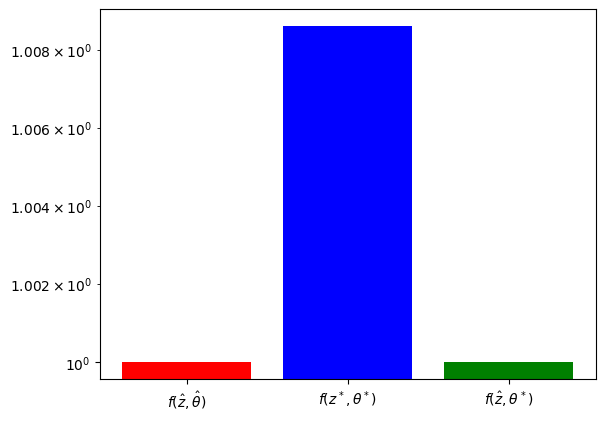

In [247]:
plt.bar(
    [r"$f(\hat{z},\hat\theta)$", r"$f(z^*,\theta^*)$", r"$f(\hat{z},\theta^*)$"],
    [
        true_optimal_sales / true_optimal_sales,
        optimal_sales / true_optimal_sales,
        dash_sales / true_optimal_sales,
    ],
    color=["red", "blue", "green"],
)
plt.yscale("log")

plt.show()

In [248]:
alpha

array([22.5889235 , 52.82663214, 45.59471247, 36.04555313, 35.27890856,
       37.69089416, 29.03708249, 51.62193769, 23.4994387 , 45.21543314,
       26.72272182, 40.76365406, 50.78734   , 31.94292733, 20.5795128 ,
       43.05510222, 59.96329289, 39.057819  , 45.89033426, 34.69480711])

In [255]:
K = 2
kf = KFold(n_splits=K, shuffle=True, random_state=0)
k_list = []
# 訓練データとテストデータをkfで分割
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

    # 訓練データで線形回帰を学習し切片、計数を取得、最適化を行い、最適な価格を取得
    lr_tilda = LinearRegression()
    lr_tilda.fit(X_test, Y_test)
    coef = lr_tilda.coef_
    intercept = lr_tilda.intercept_

    # モデルの作成
    m = gp.Model("max_sales")

    # 変数の作成
    prices = m.addVars(M, lb=r_m, ub=r_M, name="prices")

    # 目的関数の設定
    m.setObjective(gp.quicksum(coef[i] * prices[i] for i in range(M)) + intercept, GRB.MAXIMIZE)

    # 最適化
    m.optimize()

    # 価格を取得 価格を取得
    optimal_prices = np.array([prices[i].X for i in range(M)]).reshape(1, -1)

    # 最適解を表示
    print("Optimal prices:")
    for i in range(M):
        print(f"product_{i}: {prices[i].X}")

    # テストデータから回帰式を作成
    lr_hat = LinearRegression()
    lr_hat.fit(X_train, Y_train)

    # 回帰式に最適な価格を代入
    prices_hat = lr_hat.predict(optimal_prices)

    # k_listに追加
    k_list.append(prices_hat)

avg_k_list = np.mean(k_list)


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 20 columns and 0 nonzeros
Model fingerprint: 0xf976a0b7
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [6e+00, 5e+01]
  Bounds range     [6e-01, 1e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 0 rows and 20 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.7926698e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  5.792669795e+02
Optimal prices:
product_0: 1.0
product_1: 1.0
product_2: 1.0
product_3: 1.0
product_4: 1.0
product_5: 1.0
product_6: 1.0
product_7: 1.0
product_8: 1.0
product_9: 1.0
product_10: 1.

c:\Users\m-kum\kaggle\experiment1\.venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\m-kum\kaggle\experiment1\.venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [250]:
np.mean(k_list)

579.431885129381

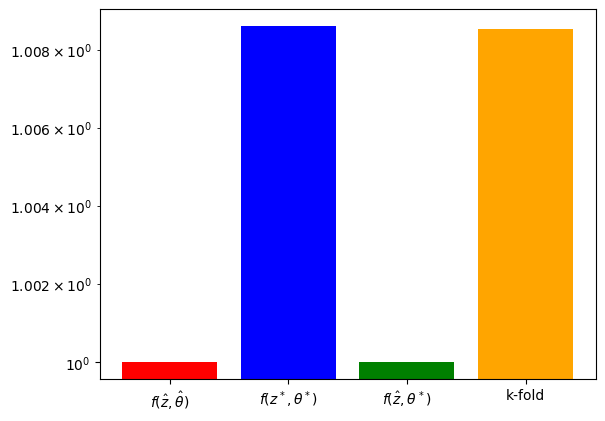

In [251]:
plt.bar(
    [r"$f(\hat{z},\hat\theta)$", r"$f(z^*,\theta^*)$", r"$f(\hat{z},\theta^*)$", r"k-fold"],
    [
        true_optimal_sales / true_optimal_sales,
        optimal_sales / true_optimal_sales,
        dash_sales / true_optimal_sales,
        avg_k_list / true_optimal_sales,
    ],
    color=["red", "blue", "green", "orange"],
)
plt.yscale("log")

plt.show()


In [252]:
dash_sales == avg_k_list

False

In [253]:
optimal_sales == dash_sales

False

In [254]:
optimal_sales == avg_k_list

False